In [1]:
import pandas as pd
pd.set_option("display.max_columns", 200)

path = "matchData.csv"

df = pd.read_csv(path, low_memory=False)
print(df.shape)
df.head(3)

(101843, 1770)


,dataVersion,matchId,endOfGameResult,gameCreation,gameDuration,gameEndTimestamp,gameId,gameMode,gameName,gameType,gameVersion,mapId,participant0PlayerScore0,participant0PlayerScore1,participant0PlayerScore10,participant0PlayerScore11,participant0PlayerScore2,participant0PlayerScore3,participant0PlayerScore4,participant0PlayerScore5,participant0PlayerScore6,participant0PlayerScore7,participant0PlayerScore8,participant0PlayerScore9,participant0AllInPings,participant0AssistMePings,participant0Assists,participant0BaronKills,participant0BasicPings,participant0ChampExperience,participant0ChampLevel,participant0ChampionId,participant0ChampionName,participant0ChampionTransform,participant0CommandPings,participant0ConsumablesPurchased,participant0DamageDealtToBuildings,participant0DamageDealtToObjectives,participant0DamageDealtToTurrets,participant0DamageSelfMitigated,participant0DangerPings,participant0Deaths,participant0DetectorWardsPlaced,participant0DoubleKills,participant0DragonKills,participant0EligibleForProgression,participant0EnemyMissingPings,participant0EnemyVisionPings,participant0FirstBloodAssist,participant0FirstBloodKill,participant0FirstTowerAssist,participant0FirstTowerKill,participant0GameEndedInEarlySurrender,participant0GameEndedInSurrender,participant0GetBackPings,participant0GoldEarned,participant0GoldSpent,participant0HoldPings,participant0IndividualPosition,participant0InhibitorKills,participant0InhibitorTakedowns,participant0InhibitorsLost,participant0Item0,participant0Item1,participant0Item2,participant0Item3,participant0Item4,participant0Item5,participant0Item6,participant0ItemsPurchased,participant0KillingSprees,participant0Kills,participant0Lane,participant0LargestCriticalStrike,participant0LargestKillingSpree,participant0LargestMultiKill,participant0LongestTimeSpentLiving,participant0MagicDamageDealt,participant0MagicDamageDealtToChampions,participant0MagicDamageTaken,participant0NeedVisionPings,participant0NeutralMinionsKilled,participant0NexusKills,participant0NexusLost,participant0NexusTakedowns,participant0ObjectivesStolen,participant0ObjectivesStolenAssists,participant0OnMyWayPings,participant0ParticipantId,participant0PentaKills,participant0Defense,participant0Flex,participant0Offense,participant0PrimaryStyle,participant0PrimaryStylePerk1,participant0PrimaryStylePerk1Var1,participant0PrimaryStylePerk1Var2,participant0PrimaryStylePerk1Var3,participant0PrimaryStylePerk2,participant0PrimaryStylePerk2Var1,...,participant9Spell2Casts,participant9Spell3Casts,participant9Spell4Casts,participant9SubteamPlacement,participant9Summoner1Casts,participant9Summoner1Id,participant9Summoner2Casts,participant9Summoner2Id,participant9SummonerId,participant9SummonerLevel,participant9SummonerName,participant9TeamEarlySurrendered,participant9TeamId,participant9TeamPosition,participant9TimeCCingOthers,participant9TimePlayed,participant9TotalAllyJungleMinionsKilled,participant9TotalDamageDealt,participant9TotalDamageDealtToChampions,participant9TotalDamageShieldedOnTeammates,participant9TotalDamageTaken,participant9TotalEnemyJungleMinionsKilled,participant9TotalHeal,participant9TotalHealsOnTeammates,participant9TotalMinionsKilled,participant9TotalTimeCCDealt,participant9TotalTimeSpentDead,participant9TotalUnitsHealed,participant9TripleKills,participant9TrueDamageDealt,participant9TrueDamageDealtToChampions,participant9TrueDamageTaken,participant9TurretKills,participant9TurretTakedowns,participant9TurretsLost,participant9UnrealKills,participant9VisionClearedPings,participant9VisionScore,participant9VisionWardsBoughtInGame,participant9WardsKilled,participant9WardsPlaced,participant9Win,team0TeamId,team0Win,team0Ban0ChampionId,team0Ban0PickTurn,team0Ban1ChampionId,team0Ban1PickTurn,team0Ban2ChampionId,team0Ban2PickTurn,team0Ban3ChampionId,team0Ban3PickTurn,team0Ban4ChampionId,team0Ban4PickTurn,team0FeatsEPIC_MONSTER_KILLFeatState,team0FeatsFIRST_BLOODFeatState,team0FeatsFIRST_TURRETFeatState,team0BaronFirst,team0BaronKills,te

In [2]:
#check for different patches
df["patch"] = df["gameVersion"].str.extract(r"^(\d+\.\d+)")

df["patch"].value_counts().head(20)

patch
15.15    40089
15.14    37900
15.16    22642
15.13     1212
Name: count, dtype: int64

In [ ]:
import numpy as np
n_games = len(df)


pick_name_series = pd.concat(
    [df[f"participant{i}ChampionName"] for i in range(10)],
    ignore_index=True
)

pick_name_counts = pick_name_series.value_counts()
pick_name_rate = (pick_name_counts / n_games).rename("pick_rate")  # per game


champ_id_list = []
champ_name_list = []

for i in range(10):
    cid_col = f"participant{i}ChampionId"
    cname_col = f"participant{i}ChampionName"
    tmp = df[[cid_col, cname_col]].dropna()
    champ_id_list.append(tmp[cid_col])
    champ_name_list.append(tmp[cname_col])

champ_map_df = pd.DataFrame({
    "championId": pd.concat(champ_id_list, ignore_index=True),
    "championName": pd.concat(champ_name_list, ignore_index=True)
})

# Drop duplicates so each ID maps to a single name
champ_map_df = champ_map_df.drop_duplicates().set_index("championId")
id_to_name = champ_map_df["championName"]

# BAN STATS (start from IDs, then map to names)
ban_id_cols = [f"team{t}Ban{i}ChampionId" for t in (0, 1) for i in range(5)]
ban_ids = df[ban_id_cols].replace(0, np.nan)  # 0 = no ban

ban_id_counts = ban_ids.stack().value_counts()           # index: championId
ban_id_rate = (ban_id_counts / n_games)                  # per game

# Convert ban stats from ID -> name
ban_name_counts = (
    ban_id_counts
    .rename_axis("championId")
    .reset_index(name="ban_count")
    .assign(championName=lambda d: d["championId"].map(id_to_name))
    .dropna(subset=["championName"])   # drop bans for champs never seen in participants (if any)
    .groupby("championName")["ban_count"]
    .sum()
)

ban_name_rate = (ban_name_counts / n_games).rename("ban_rate")

# PRESENCE (picked OR banned)
presence_name_counts = (
    pick_name_counts
    .add(ban_name_counts, fill_value=0)
    .rename("presence_count")
)
presence_name_rate = (presence_name_counts / n_games).rename("presence_rate")

# FINAL SUMMARY BY championNam
summary_by_name = pd.concat(
    [
        pick_name_counts.rename("pick_count"),
        pick_name_rate,
        ban_name_counts.rename("ban_count"),
        ban_name_rate,
        presence_name_counts,
        presence_name_rate,
    ],
    axis=1,
).fillna(0)  # champs that are never banned will have 0 ban_count/ban_rate

summary_by_name = summary_by_name.sort_values("presence_count", ascending=False)

# Top 20 by presence (picked or banned)
summary_by_name.head(20)
#save to csv

,pick_count,pick_rate,ban_count,ban_rate,presence_count,presence_rate
Kalista,1047,0.010281,193,0.001895,1240,0.012176
Skarner,1202,0.011802,402,0.003947,1604,0.015750
Shyvana,1753,0.017213,253,0.002484,2006,0.019697
Taric,1799,0.017664,355,0.003486,2154,0.021150
Renata,2019,0.019825,199,0.001954,2218,0.021779
Sejuani,2371,0.023281,193,0.001895,2564,0.025176
Maokai,2512,0.024665,222,0.002180,2734,0.026845
Gnar,2456,0.024116,408,0.004006,2864,0.028122
Rammus,1257,0.012343,1854,0.018204,3111,0.030547
Heimerdinger,2005,0.019687,1255,0.012323,3260,0.032010


In [ ]:
df["win"] = df["team0Win"].astype(int)

# Keep only numeric features
numeric_df = df.select_dtypes(include=np.number)

# Drop columns that are constant or clearly IDs
numeric_df = numeric_df.drop(columns=[
    "gameId", "matchId", "team0TeamId", "team1TeamId"
], errors="ignore")

# Compute correlation with win
corr_with_win = numeric_df.corr()["win"].sort_values(ascending=False)

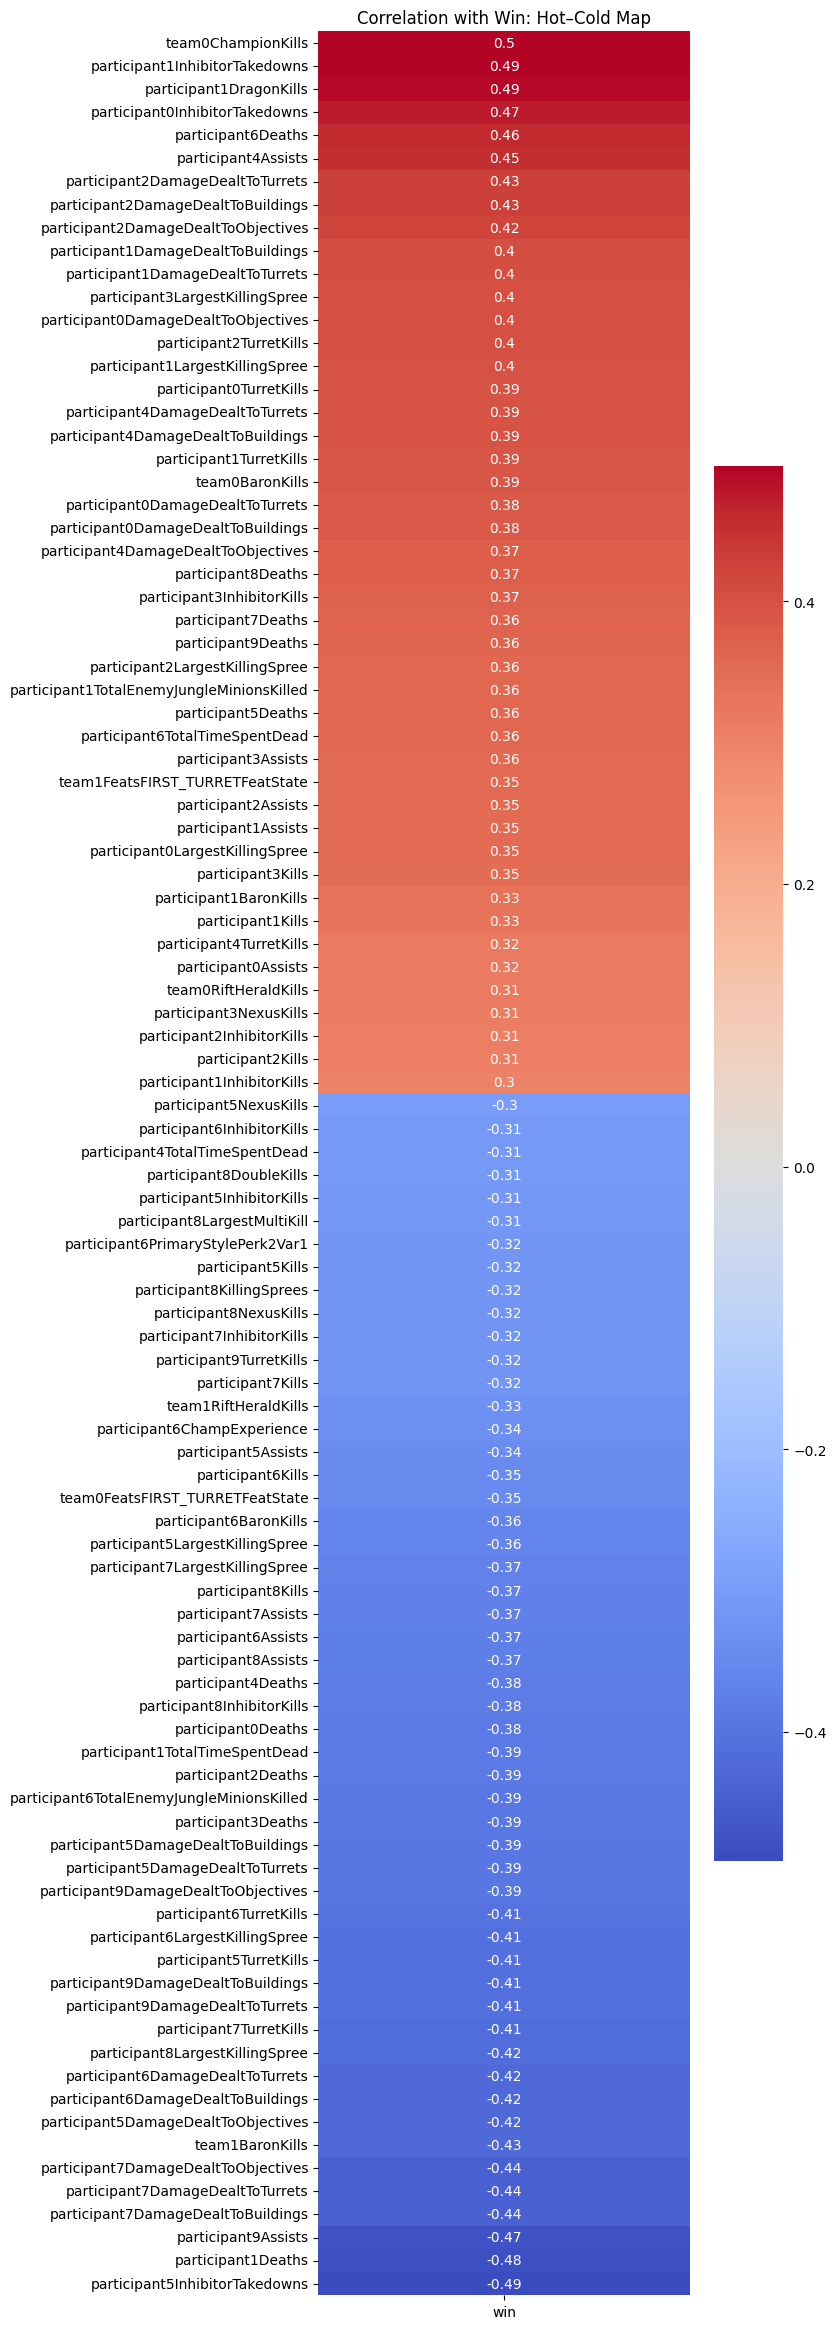

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter strong correlations only (abs > threshold)
strong = corr_with_win[(abs(corr_with_win) > 0.3) & (abs(corr_with_win) < 0.5)]

plt.figure(figsize=(6, max(6, len(strong) * 0.3)))
sns.heatmap(
    strong.to_frame(),
    cmap="coolwarm",
    annot=True,
    cbar=True
)
plt.title("Correlation with Win: Hot–Cold Map")
plt.show()
